# Benchmarking an algorithm used to solve a MAX-k-SAT problem

In this notebook we showcase functionality of qubrabench by implementing and benchmarking a hillclimbing algorithm to solve MAX-k-SAT, as described in https://arxiv.org/abs/2203.04975.
The paper describes two distinct variants of implementing the hillclimber: a simple hillclimber - which uses (quantum) search, and a steep one - which uses (quantum) max finding.

## Problem Definition: MAX-k-SAT

Max-k-SAT is a combinatorial optimization problem that given a list of clauses $(C_{i})^{p}_{i=1}$, each a disjunction of at most $k$ literals, and a set of weights $(w_{i})^{p}_{i=1}$, asks us to maximize the weight of the satisfied clauses,
$$\varphi(y) := \sum ^{p} _{i=1} w_{i}C_{i}(y),$$
over all assignments $y \in \{0, 1\}^{q}$ of the variables. This problem is NP-hard for $k ≥ 2$.

## Example Problem Instance

Let's assume that $k=3$, which means we will be solving a MAX-3-SAT problem. We will also assume that we have four variables available ($x_{1}, x_{2}, x_{3}, x_{4})$. In the course of the following sections, we will build an algorithm to solve the following problem instance:

$$(\neg x_{1} \lor \neg x_{2} \lor x_{3})_{3} \land (x_{1} \lor x_{2} \lor \neg x_{4})_{5} \land (\neg x_{1} \lor \neg x_{2} \lor x_{4})_{1}$$ 

In [ ]:
var_count = 4
demo_clauses_array = [[-1, -2, 3], [1, 2, -4], [-1, -2, 4]]
demo_weights_array = [3, 5, 1]

In this representation, each array in the demo_clauses_array represents one of the problems clauses. Each value in one of these clauses refers to one of the four available variables (e.g. $1 \equiv x_{1}$). If the value is negative, it represents a negated variable (e.g. $-1 \equiv \neg x_{1}$). The values in demo_weights_array represent the weight of the clause at the same index in the demo_clauses_array: $(...)_{weight}$.

Now that we have an array of clauses and an array of weights representing our problem instance, we can start implementing an algorithm to solve this problem. A known algorithm to solve this problem is the hillclimber algorithm, which we will be implementing in this notebook.

## Algorithm Definition: Hillclimber

For a given MAX-k-SAT problem instace, we start with a random variable assignment $y \in \{0, 1\}^{n}$ and look for improvements (higher values) of $\varphi$ in the set of all bitstrings that differ from $y$ in at most $d$ bits. All bitstrings that differ from our current solution $y$ in at most $d$ bits are collectively called the neighbourhood $N_{d}(y)$ of $y$.

### Simple Hillclimber
The simple hill climber randomly samples such assignments until it finds one with a strictly higher value of $\varphi$, which is then taken as the new assignment.
This procedure is repeated until no further improvement is found.
We can formalize each hillclimb step (described above) as searching for a solution in
$$f:N_{d}(y) \subseteq \{0,1\}^{n} →\{0,1\}$$
$$f(z) = \begin{cases}1 ~~~~~\text{if}~ \varphi(z)>\varphi(y)\\ 0 ~~~~~\text{otherwise} \end{cases}$$

### Steep Hillclimber

The steep hillclimber calculates the value of $\varphi$ for every neighbour $z \in N_{d}(y)$ of $y$. It then finds the neigbour with the highest value of $\varphi$ and uses this as the new assignment:
$$y_{new} = max_{z \in N_{d}(y)}(\varphi(z))$$
This procedure is repeated until no further improvement is found. 

# Solving our problem instance

As mentioned above, we can use a hillclimber algorithm to solve the MAX-k-SAT problem. For the purpose of simplicity within this notebook, we will be focussing on the steep hillclimber. Side note: This repository also contains a [hillclimber algorithm](https://github.com/qubrabench/qubrabench/blob/notebooks/examples/sat/bench_hillclimber.py), which uses a more advanced approach and has much better performance than our approach. However, as we are focussing on the functionality of qubrabench in this notebook, this more complex implementation will not be covered in more detail.

## Implementing the steep hillclimber algorithm

To solve a MAX-k-SAT problem instance, consisting of a set auf clauses $(C_{i})^{p}_{i=1}$ and a set of weights $(w_{i})^{p}_{i=1}$, we will implement a steep hillclimber algorithm. We start by importing two libraries we will need in the course of this implementation.

In [ ]:
import itertools
import random

We will assume, that $d=1$, which enables us to simplify some of our functions. This means, when we look at the neighbourhood of a given variable assignment $y$, we will always be looking at assignments $z\in N_{1}(y)$, that differ from our current assignment in exactly one place.

To get our first variable assignment we implement a function, which randomly generates a sequence of zeros and ones. 

In [ ]:
def generate_random_assignment(variable_count):
    return [random.randint(0, 1) for _ in range(variable_count)]


random_assignment = generate_random_assignment(var_count)
print("Random assignment: " + str(random_assignment) + ", which means:")

for i in range(len(random_assignment)):
    print("x" + str(i + 1) + " = " + str(random_assignment[i]))

Random assignment: [1, 1, 0, 0], which means:
x1 = 1
x2 = 1
x3 = 0
x4 = 0


Such a sequence represents a random variable assignment $y$ for our problem instance. Once we have this variable assignment, we are able to calculate the weight of the clause for the given assignment.
$$\varphi(y) := \sum ^{p} _{i=1} w_{i}C_{i}(y),$$

In [ ]:
def calculate_weight_for_solution(solution, clauses_array, weights_array):
    weight = 0
    for i in range(len(clauses_array)):
        for value in clauses_array[i]:
            if value > 0:
                if solution[value - 1] == 1:
                    weight += weights_array[i]
                    break
            elif value < 0:
                if solution[abs(value) - 1] == 0:
                    weight += weights_array[i]
                    break
    return weight


current_weight = calculate_weight_for_solution(
    random_assignment, demo_clauses_array, demo_weights_array
)
print("Current weight: " + str(current_weight))

Current weight: 5


We now have a starting point to run our algorithm. Because we chose a random variable assignment, we can not be sure, that we have an optimal solution to our problem. We therefor take a look at the neighbourhood of our random assignment, to check if there is an assignment with an even better weight then the current one.

In [ ]:
def get_neighbours(array):
    arrays = set()
    for i in range(len(array)):
        new_array = list(array)
        new_array[i] = 1 if array[i] == 0 else 0
        arrays.add(tuple(new_array))
    arrays.discard(tuple(array))
    return list(arrays)


get_neighbours(random_assignment)
print(random_assignment)
print(get_neighbours(random_assignment))

[1, 1, 0, 0]
[(0, 1, 0, 0), (1, 0, 0, 0), (1, 1, 1, 0), (1, 1, 0, 1)]


For each of these neighbours we need to calculate the weight the clause has with this solution. We then compute the maximum for all weights and return the neighbour with the highest weight.

In [ ]:
def find_better_assignment(solution, weight, clauses_array, weights_array):
    neighbours = get_neighbours(random_assignment)
    neighbour_weights = []
    for neighbour in neighbours:
        neighbour_weights.append(
            (
                neighbour,
                calculate_weight_for_solution(neighbour, clauses_array, weights_array),
            )
        )
    return max(neighbour_weights, default=solution, key=lambda x: x[1])


highest_solution, highest_weight = find_better_assignment(
    random_assignment, current_weight, demo_clauses_array, demo_weights_array
)

print("Highest weight: " + str(highest_weight))
print("Highest solution: " + str(highest_solution))

Highest weight: 9
Highest solution: (0, 1, 0, 0)


We then pick the neighbour with the highest weight, and if this weight is bigger than the current weight, we will use this solution and repeat this process until there is no more improvement. The optimal weight for a given assignment in this case is 9.

These steps we went through now form our hillclimber algorihm, which runs through this cycle multiple times.

In [ ]:
def hill_climber_sat(clauses_array, weights_array, variable_count):
    # Example assignment, chosen to be able to demonstrate multiple steps
    current_solution = [0, 0, 0, 1]
    print("Starting with assignment: " + str(current_solution))
    print(
        "Current weight: "
        + str(
            calculate_weight_for_solution(
                current_solution, clauses_array, weights_array
            )
        )
        + "\n"
    )

    while True:
        weight = calculate_weight_for_solution(
            current_solution, clauses_array, weights_array
        )
        better_solution, better_weight = find_better_assignment(
            current_solution, weight, clauses_array, weights_array
        )
        if weight < better_weight:
            current_solution = better_solution
            weight = better_weight
            print("Found better weight: " + str(weight) + "\n")
        else:
            print("No better weight found." + "\n")
            print(
                "Completed. Optimal assignment: "
                + str(better_solution)
                + ". Weight: "
                + str(better_weight)
                + "."
            )
            return


hill_climber_sat(demo_clauses_array, demo_weights_array, 4)

Starting with assignment: [0, 0, 0, 1]
Current weight: 4

Found better weight: 9

No better weight found.

Completed. Optimal assignment: (0, 1, 0, 0). Weight: 9.



## Spottig a pattern

If we take another look at this approach, we will notice, that we calculate the maximum value of a set of numbers within the find_better_assignment function. In this case the maximum weight amongst the weights of all neighbours using the Python max function. 

As it happens there is also a very well known max function, which runs on quantum computers, as described in the paper mentioned in the introduction. With this in mind, the question naturally occurs, what would happen if we ran the computation of max on a quantum machine using this quantum max function and if this would have any performance improvements.

This library offers a function, which enables a user to simulate doing exactly this and to keep track of runtime stats and approximations for quantum call counts, if the quantum max function was used and run on a quantum machine.

## Max Function

The library includes a set of common functions you would need in various circumstances, for example the search and the max function. These return the result you would expect from other implementations of these functions, and at the same time add in quantum benchmarking functionality. This simultaneously makes it easier to understand the use-cases of the library and makes it relatively easy to adapt existing code to use quantum benchmarking.

When we talk about quantum benchmarking here, we mean approximating the amount of calls needed to execute the function with identical parameters on a quantum computer. This library achieves this by counting the calls run on the classical (in this case most likely your) machine and basing performance assumptions on these measurements. All provided functions in qubrabench currently require a stats object, in which these collected statistics and approximations are stored.

Let's take a look at the docstrings of the function we will need to solve our problem - max.

In [ ]:
from qubrabench.algorithms.max import max as qmax

%pdoc qmax

Class docstring:
    Find the largest element in a list, while keeping track of query statistics.
    
    Args:
        iterable: iterable to find the maximum in
        default: default value to return if iterable is empty.
        key: function that maps iterable elements to values that are comparable. By default, use the iterable elements.
        error: upper bound on the failure probability of the quantum algorithm.
        stats: object that keeps track of statistics.
    
    Raises:
        ValueError: Raised when the failure rate `error` is not provided and statistics cannot be calculated.
        ValueError: Raised when iterable is an empty sequence and no default is provided.
    
    Returns:
        the desired maximum element
Call docstring:
    Call self as a function.

As you will notice, the arguments for this max function are very similar to the Python max function. Indeed, one could run this function instead of max with the same parameters and would get the wanted functionality. However it is also possible to supply this function with two additional arguments - error and stats - which enables us to keep track of the calculated statistics.

To demonstrate this, we will rewrite the find_better_assignment function from above to use the qubrabench max function. This is simply done by importing this function with the name max. We also create a stats object as provided by qubrabench and pass this to the max function together with a value for the error argument. Now we can run the same hill_climber function we defined above and take a look at the stats object after it ran using the redefined find_better_assignment function.

In [ ]:
from qubrabench.algorithms.max import max
from qubrabench.stats import QueryStats

stats = QueryStats()


def find_better_assignment(solution, weight, clauses_array, weights_array):
    neighbours = get_neighbours(random_assignment)
    neighbour_weights = []
    for neighbour in neighbours:
        neighbour_weights.append(
            (
                neighbour,
                calculate_weight_for_solution(neighbour, clauses_array, weights_array),
            )
        )
    return max(
        neighbour_weights,
        default=solution,
        key=lambda x: x[1],  # up to here, we have changed nothing
        error=10**-5,  # these two arguments are the only additions we will make
        stats=stats,
    )


hill_climber_sat(demo_clauses_array, demo_weights_array, 4)

print("\n" + str(stats))

Starting with assignment: [0, 0, 0, 1]
Current weight: 4

Found better weight: 9

No better weight found.

Completed. Optimal assignment: (0, 1, 0, 0). Weight: 9.

QueryStats(classical_control_method_calls=0, classical_actual_queries=8, classical_expected_queries=8, quantum_expected_classical_queries=0, quantum_expected_quantum_queries=145.45960000000002)


As you can see in this example, the effort to implement the qubrabench max function was very minimal and hardly invasive in our code. At the same time, it enabled us to gain valueable insight into our query statistics regarding the use of a quantum algorithm. As we can see, using the quantum max algorithm would worsen our runtime for this small problem instance. However there are cases in which there are expected benefits for the runtime. These only occur in very large problem instances, which would take very long to run with our hillclimber implementation.

In the following section we will be running the hillclimber provided in this library, because it runs much faster for larger problem instances. This will nonetheless be sufficient to demonstrate how these benchmarking results may look.

## Advanced Benchmarking

The imported `run` function executes the hillclimber on a random instance and returns the statistics in a pandas DataFrame.

In [ ]:
from hillclimber import run

With this function, we can run the hillclimber multiple times and then compute the average of the results.

Let's run the steep hill climber for $n = 100$, $n = 300$ and $n=1000$. We will run the hill climber five times for each $n$ and consistently use $k = 3$.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
%%time
data_100 = run(
    k=3,
    r=3,
    n=100,
    n_runs=5,
    rng=np.random.default_rng(seed=100),
    error=10**-5,
    steep=True,
)
data_100

CPU times: user 1.07 s, sys: 617 ms, total: 1.69 s
Wall time: 193 ms


,classical_control_method_calls,classical_actual_queries,classical_expected_queries,quantum_expected_classical_queries,quantum_expected_quantum_queries,n,k,r
0,23,2300,2300,0,44076.472908,100,3,3
1,25,2500,2500,0,47909.209683,100,3,3
2,27,2700,2700,0,51741.946458,100,3,3
3,21,2100,2100,0,40243.736134,100,3,3
4,24,2400,2400,0,45992.841296,100,3,3


In [ ]:
%%time
data_300 = run(
    k=3,
    r=3,
    n=300,
    n_runs=5,
    rng=np.random.default_rng(seed=100),
    error=10**-5,
    steep=True,
)
data_300

CPU times: user 4.36 s, sys: 1.87 s, total: 6.23 s
Wall time: 793 ms


,classical_control_method_calls,classical_actual_queries,classical_expected_queries,quantum_expected_classical_queries,quantum_expected_quantum_queries,n,k,r
0,66,19800,19800,0,255680.842625,300,3,3
1,78,23400,23400,0,302168.268557,300,3,3
2,66,19800,19800,0,255680.842625,300,3,3
3,73,21900,21900,0,282798.507752,300,3,3
4,74,22200,22200,0,286672.459913,300,3,3


In [ ]:
%%time
data_500 = run(
    k=3,
    r=3,
    n=500,
    n_runs=5,
    rng=np.random.default_rng(seed=100),
    error=10**-5,
    steep=True,
)
data_500

CPU times: user 16.4 s, sys: 7.18 s, total: 23.6 s
Wall time: 3.03 s


,classical_control_method_calls,classical_actual_queries,classical_expected_queries,quantum_expected_classical_queries,quantum_expected_quantum_queries,n,k,r
0,128,64000,64000,0,698289.306020,500,3,3
1,105,52500,52500,0,572815.446345,500,3,3
2,106,53000,53000,0,578270.831548,500,3,3
3,122,61000,61000,0,665556.994800,500,3,3
4,126,63000,63000,0,687378.535613,500,3,3


## Plotting
Finally, after we have benchmarked the solving of a couple of our problem instances, we can take a look at the plotting functionality qubrabench provides. We use the `PlottingStrategy` wrapper to define our plot parameters and configuration.

In [ ]:
from qubrabench.utils.plotting_strategy import PlottingStrategy


class Plotter(PlottingStrategy):
    def __init__(self):
        self.colors[""] = "blue"

    def get_plot_group_column_names(self):
        return ["k", "r"]

    def get_data_group_column_names(self):
        """
        Generate a data line for each unique value in the specified columns.
        Useful if you the data was generated with different tags based on implementation source, parameter choice etc., that one wants to compare against in a single plot.

        Example: ["impl"] - a line will be generated for each unique `impl` label.
        """
        return []

    def compute_aggregates(self, data, *, quantum_factor):
        # compute combined query costs of quantum search
        c = data["quantum_expected_classical_queries"]
        q = data["quantum_expected_quantum_queries"]
        data["quantum_cost"] = c + quantum_factor * q
        return data

    def x_axis_column(self):
        return "n"

    def x_axis_label(self):
        return "$n$"

    def y_axis_label(self):
        return "Queries"

    def get_column_names_to_plot(self):
        return {
            "classical_actual_queries": ("Classical Queries", "o"),
            "quantum_cost": ("Quantum Queries", "x"),
        }

We can put all the benchmark stats in a single table and run the plotter. 

In [ ]:
%pdoc Plotter.plot

Class docstring:
    Plot benchmarking data.
    
    Args:
        data: a pandas DataFrame containing all the benchmark data.
        quantum_factor: conversion factor for the cost of a quantum query (w.r.t. classical queries).
        y_lower_lim: lower limit on the Y-axis (useful if the data starts at a large value)
    
    Raises:
        ValueError: if no columns are given to plot
Call docstring:
    Call self as a function.

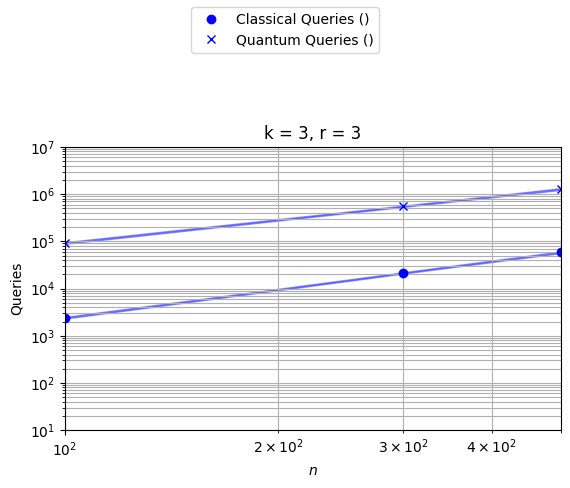

In [ ]:
data = pd.concat([data_100, data_300, data_500])
Plotter().plot(data, quantum_factor=2, y_lower_lim=10)

Now we can also run the "steep" hillclimber for the above instance sizes, and compare the two benchmarks.

In [ ]:
%%time
data_steep = [
    run(
        k=3,
        r=3,
        n=n,
        n_runs=5,
        rng=np.random.default_rng(seed=100),
        error=10**-5,
        steep=True,
    )
    for n in [100, 300, 500]
]
data_steep = pd.concat(data_steep)

CPU times: user 22.1 s, sys: 9.16 s, total: 31.3 s
Wall time: 3.99 s


In [ ]:
# add an extra column to distinguish the source (i.e. type of hillclimb)
full_data = []
for d, is_steep in [(data, False), (data_steep, True)]:
    d = d.copy()
    d.insert(0, "steep", is_steep)
    full_data.append(d)
full_data = pd.concat(full_data)

We modify the above plotter a bit as we now want to group the data by column "steep" (in the same plot).

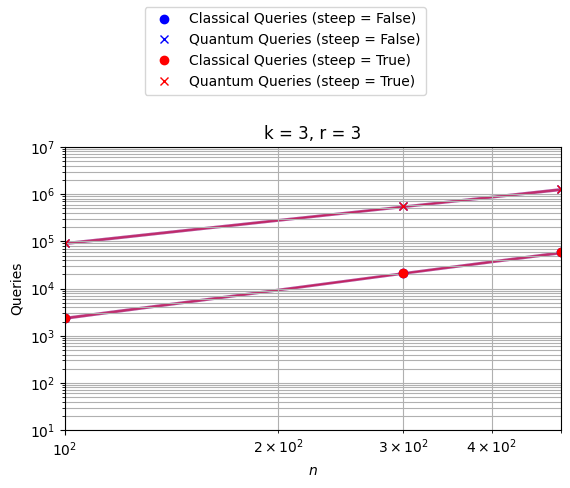

In [ ]:
class FullPlotter(Plotter):
    def __init__(self):
        self.colors["steep = False"] = "blue"
        self.colors["steep = True"] = "red"

    def get_data_group_column_names(self):
        return ["steep"]


FullPlotter().plot(full_data, quantum_factor=2, y_lower_lim=10)